## CNN architecture

#### The architecture that is used in this classification problem is as follows
* Input Image (shape : 1X1X28X28)
* Convolutional Filter of shape 2X1X5X5
* ReLU function
* 2X2 Maxpooling layer
* 1st Fully Connected Layer with 288 units
* 2nd Fully Connected Layer of 60 units activated with ReLU function
* Output Layer with 10 units normalized by a softmax function

In the following sections I will implement convolution, ReLU, softmax, and maxpool functions

### Data Loading and Preprocessing

In [19]:
import numpy as np
from matplotlib import pyplot as plt
from helpers import normalize_dataset

In [20]:
def one_hot_encode(labels: np.ndarray):
    '''
    One-Hot encode labels
    
    @param labels array of labels
    
    @return one-hot encoded labels
    '''
    casted_labels = labels.astype(int)
    return np.eye(np.unique(casted_labels).shape[0])[casted_labels]

def reshape_flat_square_images(images: np.ndarray, num_channels: int):
    '''
    Reshape to be a square
    
    @param image N x TOTAL_PIXELS
    @param num_channels number of channels

    @return N x CHANNELS x HEIGHT x WIDTH
    '''
    dims = np.sqrt(images.shape[1])
    if not dims.is_integer():
        raise ValueError('Image is not square')
    dims = int(dims)
    return images.reshape(images.shape[0], num_channels, dims, dims)

In [21]:
training = np.loadtxt("dataset/train.csv", delimiter=",", dtype=str) # load training data
training_labels = one_hot_encode(training[1:, 0]) # first column is labels
training_data = reshape_flat_square_images(normalize_dataset(training[1:, 1:]), 1) # rest of columns are grayscale data

print("# Training Samples: " + str(training_labels.shape[0]))
print("# Classes: " + str(training_labels.shape[1]))
print("Image Height: " + str(training_data.shape[2]))
print("Image Width: " + str(training_data.shape[3]))

# Training Samples: 38000
# Classes: 10
Image Height: 28
Image Width: 28


In [22]:
testing = np.loadtxt("dataset/test.csv", delimiter=",", dtype=str)
testing_labels = one_hot_encode(testing[1:, 0])
testing_data = reshape_flat_square_images(normalize_dataset(testing[1:, 1:]), 1)

print("# Testing Samples: " + str(testing_labels.shape[0]))
print("# Classes: " + str(testing_labels.shape[1]))
print("Image Height: " + str(testing_data.shape[2]))
print("Image Width: " + str(testing_data.shape[3]))

# Testing Samples: 4000
# Classes: 10
Image Height: 28
Image Width: 28


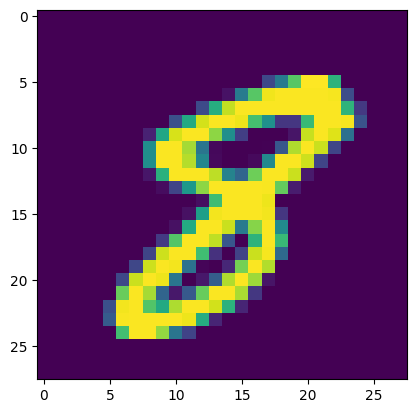

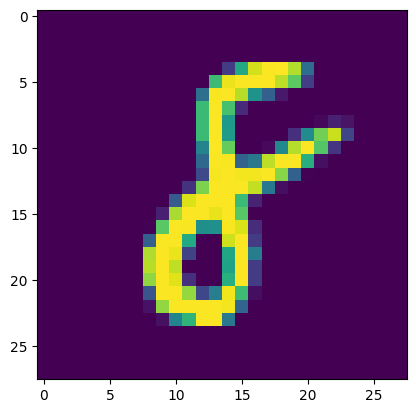

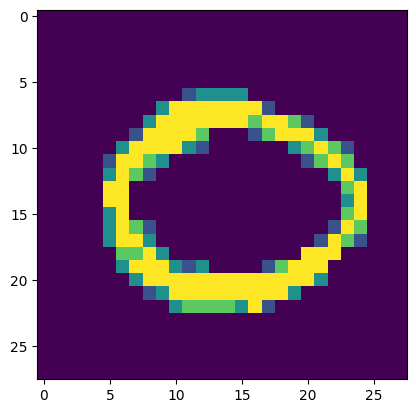

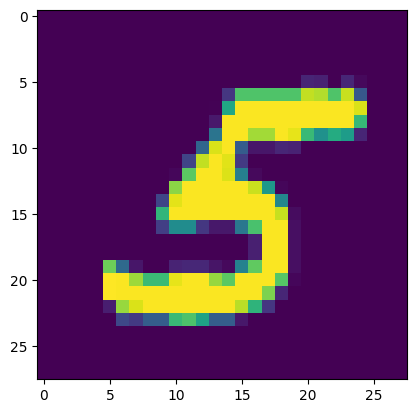

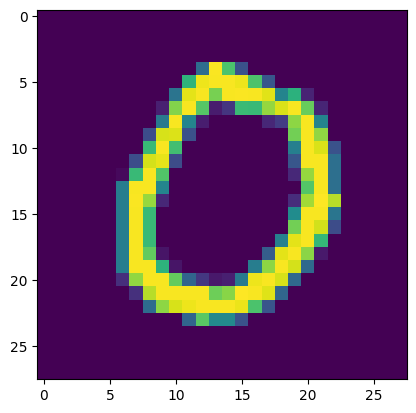

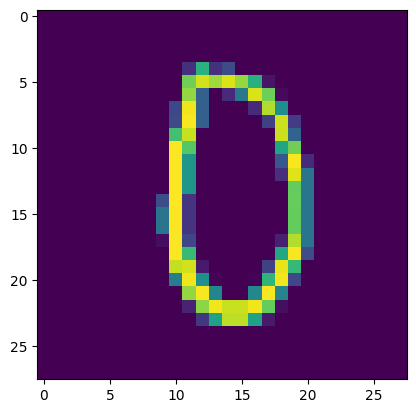

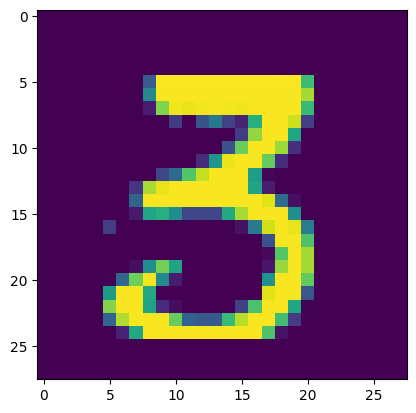

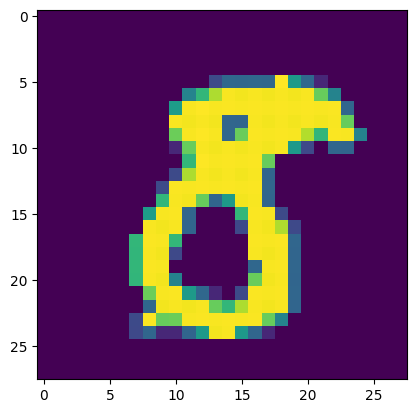

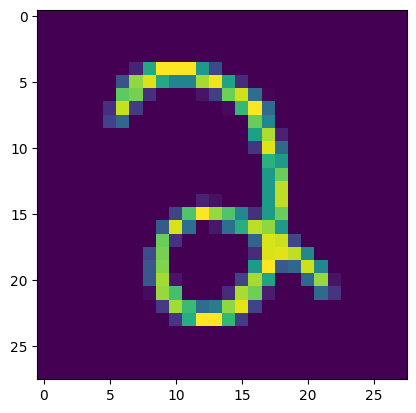

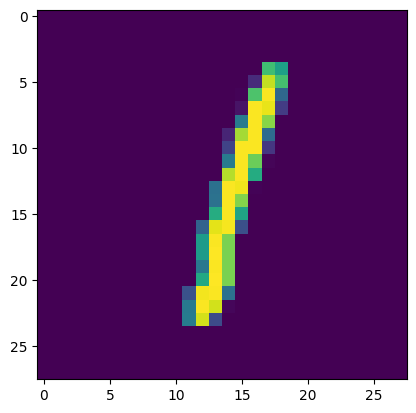

In [23]:
for i in range(10):
    plt.imshow(training_data[i, 0])
    plt.pause(0.5)

### Forward Pass Functions

In [24]:
def im2col(data: np.ndarray, conv: np.ndarray, stride: int, pad: int):
    '''
    Transforms a batch of images into a matrix
    
    @param data N x CHANNELS x HEIGHT x WIDTH input images
    @param conv NUM_FILTERS x CHANNELS x CONV_SIZE x CONV_SIZE convolutional layer
    @param stride number of pixels to move the filter each time
    @param pad number of pixels to pad the image with

    @return CONV_SIZE^2 x (NEW_WIDTH * NEW_HEIGHT * NUM_IMAGES)
    '''
    data_padded = np.pad(data, ((0,0), (0,0), (pad, pad), (pad, pad)), mode='constant')
    
    num_images, num_channels, image_height, image_width = data_padded.shape
    assert image_height == image_width, 'Input images must be square'
    
    _, _, conv_height, conv_width = conv.shape
    assert conv_width == conv_height, 'Convolutional layer must be square'
    
    output_size = int((image_height + (2 * pad) - conv_height) / stride) + 1
    
    # create a 4D view of the padded data to extract image patches
    # view has shape (num_images, num_channels, output_size, output_size, conv_height, conv_width)
    data_view = np.lib.stride_tricks.as_strided(data_padded,
                                                shape=(num_images, num_channels, output_size, output_size, conv_height, conv_width),
                                                strides=(data_padded.strides[0], data_padded.strides[1], 
                                                         stride * data_padded.strides[2], stride * data_padded.strides[3], 
                                                         data_padded.strides[2], data_padded.strides[3]))
    
    # reshape the view to a 2D array
    # the shape of the array is (num_images * output_size * output_size, num_channels * conv_height * conv_width)
    im2col_vector = data_view.reshape(num_images * output_size * output_size, num_channels * conv_height * conv_width)
    
    return im2col_vector.T # transpose the matrix to match the expected output shape

def convolve(data: np.ndarray, im2col_result: np.ndarray, conv: np.ndarray, stride: int):
    '''
    Convolves the data with the im2col result
    
    @param data N x CHANNELS x HEIGHT x WIDTH input images
    @param im2col_result CONV_SIZE * CONV_SIZE x NEW_WIDTH * NEW_HEIGHT * NUM_IMAGES
    @param conv NUM_FILTERS x CHANNELS x CONV_SIZE x CONV_SIZE convolutional layer
    @param stride number of pixels to move the filter each time
    
    @return NUM_IMAGES x NUM_FILTERS x NEW_HEIGHT x NEW_WIDTH
    '''
    _, _, height, width = data.shape
    assert height == width, 'Input images must be square'
    
    _, _, conv_height, conv_width = conv.shape
    assert conv_width == conv_height, 'Convolutional layer must be square'
    
    new_size = int(((height - conv_height) / stride)) + 1
    
    conv_reshaped = conv.reshape(conv.shape[0], -1)
    conv_out = conv_reshaped @ im2col_result
    return np.array(np.hsplit(conv_out,data.shape[0])).reshape((data.shape[0], conv.shape[0], new_size, new_size))

def ReLU(x: np.ndarray):
    '''
    Rectified Linear Unit activation function
    
    @param x input to the activation function
    
    @return x if x > 0, 0 otherwise
    '''
    return (x > 0) * x

def softmax(data: np.ndarray):
    '''
    Computes the softmax function for each row of the input x.
    
    @param data N x D matrix where N is the number of samples and D is the number of classes
    
    @return N x D matrix where each row is a valid probability distribution
    '''
    data_exp = np.exp(data-np.max(data))
    
    return data_exp / np.sum(data_exp, axis=0)

def maxpool(data: np.ndarray, pool_size: int, stride: int, calc_indices: bool):
    '''
    Computes the maxpooling of the input data
    
    @param data N x CHANNELS x HEIGHT x WIDTH input images
    @param pool_size size of the pooling filter
    @param stride number of pixels to move the filter each time
    
    @return if calc_indices:
            A tuple (max_output, indices) where:
            max_output is N x CHANNELS x NEW_HEIGHT x NEW_WIDTH
            indices is N x CHANNELS x NEW_HEIGHT x NEW_WIDTH x pool_size^2
            else:
            N x CHANNELS x NEW_HEIGHT x NEW_WIDTH
    '''
    # Get input shape
    N, C, H, W = data.shape

    # Compute output shape
    OH = (H - pool_size) // stride + 1
    OW = (W - pool_size) // stride + 1

    # Pad input data to handle edge cases
    pad_height = ((OH - 1) * stride + pool_size - H) // 2
    pad_width = ((OW - 1) * stride + pool_size - W) // 2
    data = np.pad(data, ((0, 0), (0, 0), (pad_height, pad_height), (pad_width, pad_width)), mode='constant')

    # Create view of data with desired strides
    data_strided = np.lib.stride_tricks.as_strided(data,
                                                shape=(N, C, OH, OW, pool_size, pool_size),
                                                strides=(data.strides[0],
                                                         data.strides[1],
                                                         stride * data.strides[2],
                                                         stride * data.strides[3],
                                                         data.strides[2],
                                                         data.strides[3]))

    # Compute max pooling and indices
    max_output = np.max(data_strided, axis=(4, 5))
    if calc_indices:
        indices = np.argmax(data_strided, axis=4), np.argmax(data_strided, axis=5)
        indices = np.ravel_multi_index(indices, (pool_size, pool_size))
        idx_h, idx_w = np.unravel_index(indices, (pool_size, pool_size))
        idx_h = idx_h.reshape(N, C, OH, OW, -1)
        idx_w = idx_w.reshape(N, C, OH, OW, -1)
        indices = np.concatenate((idx_h, idx_w), axis=-1)
        return max_output, indices
    return max_output

### Functions for Backpropagation

In [25]:
def dReLU(x: np.ndarray):
    '''
    Derivative of the Rectified Linear Unit activation function
    
    @param x input to the activation function
    
    @return 1.0 if x > 0, 0 otherwise
    '''
    return (x > 0) * 1.0

def unpool_with_indices(delta_maxpool: np.ndarray, maxpool_indices: np.ndarray, pool_size: int):
    '''
    Unpools the given delta_maxpool using the maxpool_indices.
    
    @param delta_maxpool N x CHANNELS x HEIGHT x WIDTH array of max-pooled gradients
    @param maxpool_indices N x CHANNELS x NEW_HEIGHT x NEW_WIDTH x pool_size^2 array of indices
    @param pool_size size of the pooling filter used in the max-pooling operation
    
    @return delta_unpooled N x CHANNELS x (HEIGHT * pool_size) x (WIDTH * pool_size) array of unpooled gradients
    '''
    N, C, _, _, _ = maxpool_indices.shape
    _, _, H, W = delta_maxpool.shape

    delta_unpooled = np.zeros((N, C, H * pool_size, W * pool_size), dtype=delta_maxpool.dtype)

    for i in range(pool_size):
        for j in range(pool_size):
            mask = (maxpool_indices[..., 0] == i) & (maxpool_indices[..., 1] == j)
            delta_unpooled[..., i::pool_size, j::pool_size] += delta_maxpool * mask

    return delta_unpooled

### Parameters

In [26]:
# training loop parameters
epochs = 50
batch_size = 128
batches = training_data.shape[0] // batch_size

# network parameters
W0 = np.random.rand(60, 288) / np.sqrt(288)
B0 = np.zeros((60, 1)) / np.sqrt(288)
W1 = np.random.rand(10, 60) / np.sqrt(60)
B1 = np.zeros((10, 1)) / np.sqrt(60)
conv_layer = np.random.randn(2, 1, 5, 5) * np.sqrt(1. / 5.)

# conv layer parameters
conv_stride = 1
conv_pad = 0

# maxpool parameters
maxpool_stride = 2
maxpool_size = 2

# hyperparameters
learning_rate = 0.001

# adam optimizer parameters
beta1 = 0.9
beta2 = 0.995
momentum_w0 = 0
momentum_w1 = 0
momentum_b0 = 0
momentum_b1 = 0
momentum_conv = 0
velocity_w0 = 0
velocity_w1 = 0
velocity_b0 = 0
velocity_b1 = 0
velocity_conv = 0
alpha = 0.0000001

### Training Loop

In [28]:
best_W0 = None
best_W1 = None
best_B0 = None
best_B1 = None
best_conv_layer = None
best_accuracy = 0
validation_accuracies = []
for epoch_num in range(epochs):
    permutation = np.random.permutation(training_data.shape[0])
    scrambled_data = training_data[permutation]
    scrambled_labels = training_labels[permutation]
    for i in range(batches):
        start_index = i * batch_size
        end_index = min(start_index + batch_size, training_data.shape[0] - 1)
        data_batch = scrambled_data[start_index:end_index]
        label_batch = scrambled_labels[start_index:end_index].T
        
        # pass through Convolutional Layer
        data_im2col = im2col(data_batch, conv_layer, conv_stride, conv_pad)
        conv_out = convolve(data_batch, data_im2col, conv_layer, conv_stride)
        
        # pass through ReLU
        conv_out_relu = ReLU(conv_out)
        
        # pass Through Max Pool
        maxpool_out, maxpool_indices = maxpool(conv_out_relu, maxpool_size, maxpool_stride, True)
        maxpool_out_flatten = maxpool_out.reshape(maxpool_out.shape[0], -1).T # flatten the maxpool output
        
        # pass into fully connected layers
        fully_connected_out = ReLU(W0 @ maxpool_out_flatten + B0)
        final_out = softmax(W1 @ fully_connected_out + B1)

        # calculate gradients       
        loss = final_out - label_batch
        delta_1 = (W1.T @ loss) * dReLU(fully_connected_out)
        delta_0 = W0.T @ delta_1
        
        dW0 = delta_1 @ maxpool_out_flatten.T
        dW1 = loss @ fully_connected_out.T
        dB0 = np.sum(delta_1, axis=1, keepdims=True)
        dB1 = np.sum(loss, axis=1, keepdims=True)
        
        ### calculate error for last layer before flattening
        delta_maxpool = delta_0.reshape(maxpool_out.shape)
        
        ### calculate error for previous convolutional layer
        delta_unpool = unpool_with_indices(delta_maxpool, maxpool_indices, 2) * dReLU(conv_out)
        delta_unpool_reshaped = delta_unpool.transpose(1, 0, 2, 3).reshape(delta_unpool.shape[1], -1)
        delta_conv = (delta_unpool_reshaped @ data_im2col.T).reshape(conv_layer.shape)
        
        # Adam optimizer
        momentum_w0 = beta1 * momentum_w0 + ((1 - beta1) * dW0)
        momentum_w1 = beta1 * momentum_w1 + ((1 - beta1) * dW1)
        momentum_b0 = beta1 * momentum_b0 + ((1 - beta1) * dB0)
        momentum_b1 = beta1 * momentum_b1 + ((1 - beta1) * dB1)
        momentum_conv = beta1 * momentum_conv + ((1 - beta1) * delta_conv)
        velocity_w0 = beta2 * velocity_w0 + ((1 - beta2) * dW0 ** 2)
        velocity_w1 = beta2 * velocity_w1 + ((1 - beta2) * dW1 ** 2)
        velocity_b0 = beta2 * velocity_b0 + ((1 - beta2) * dB0 ** 2)
        velocity_b1 = beta2 * velocity_b1 + ((1 - beta2) * dB1 ** 2)
        velocity_conv = beta2 * velocity_conv + ((1 - beta2) * delta_conv ** 2)
        
        # update weights and biases
        conv_layer -= learning_rate * momentum_conv / np.sqrt(velocity_conv + alpha)
        W0 -= learning_rate * momentum_w0 / np.sqrt(velocity_w0 + alpha)
        W1 -= learning_rate * momentum_w1 / np.sqrt(velocity_w1 + alpha)
        B0 -= learning_rate * momentum_b0 / np.sqrt(velocity_b0 + alpha)
        B1 -= learning_rate * momentum_b1 / np.sqrt(velocity_b1 + alpha)
        
    # validation forward pass
    validate_im2col = im2col(testing_data, conv_layer, conv_stride, conv_pad)
    validate_convolve = ReLU(convolve(testing_data, validate_im2col, conv_layer, conv_stride))
    validate_maxpool = maxpool(validate_convolve, maxpool_size, maxpool_stride, False)
    validate_maxpool_flat = validate_maxpool.reshape(validate_maxpool.shape[0], -1).T
    validate_fully_connected = ReLU(W0 @ validate_maxpool_flat + B0)
    validate_accuracy = np.mean(np.argmax(testing_labels.T, axis=0) == np.argmax(
        softmax(W1 @ validate_fully_connected + B1), axis=0)) * 100
    if validate_accuracy > best_accuracy:
        best_accuracy = validate_accuracy
        best_W0 = np.copy(W0)
        best_W1 = np.copy(W1)
        best_B0 = np.copy(B0)
        best_B1 = np.copy(B1)
        best_conv_layer = np.copy(conv_layer)
    validation_accuracies.append(validate_accuracy)
    print("Epoch: " + str(epoch_num + 1) + "/" + str(epochs))
    print("Accuracy: " + str(round(validate_accuracy, 2)) + "%")
    print("---------------------------------")
    
print("Best Accuracy: " + str(round(best_accuracy, 2)) + "%")

Epoch: 1/50
Accuracy: 91.15%
---------------------------------
Epoch: 2/50
Accuracy: 92.75%
---------------------------------
Epoch: 3/50
Accuracy: 93.22%
---------------------------------
Epoch: 4/50
Accuracy: 93.78%
---------------------------------
Epoch: 5/50
Accuracy: 94.18%
---------------------------------
Epoch: 6/50
Accuracy: 94.6%
---------------------------------
Epoch: 7/50
Accuracy: 95.22%
---------------------------------
Epoch: 8/50
Accuracy: 95.2%
---------------------------------
Epoch: 9/50
Accuracy: 95.5%
---------------------------------
Epoch: 10/50
Accuracy: 95.38%
---------------------------------
Epoch: 11/50
Accuracy: 95.98%
---------------------------------
Epoch: 12/50
Accuracy: 95.7%
---------------------------------
Epoch: 13/50
Accuracy: 96.08%
---------------------------------
Epoch: 14/50
Accuracy: 96.38%
---------------------------------
Epoch: 15/50
Accuracy: 96.38%
---------------------------------
Epoch: 16/50
Accuracy: 96.08%
-----------------------

### Plot Results

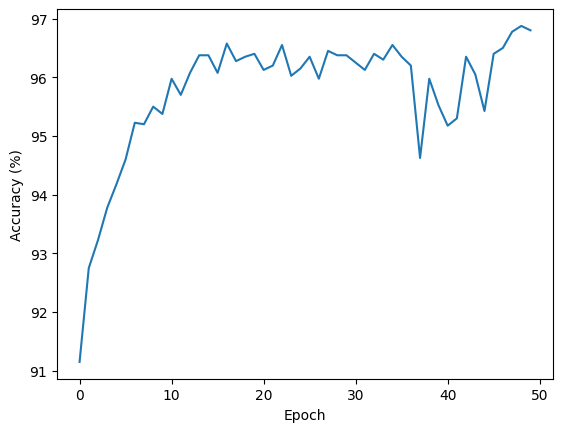

In [29]:
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.plot(range(epochs), validation_accuracies)

### Saving the weights

In [30]:
import pickle as pkl
param_dict = {
    'W0' : best_W0,
    'B0' : best_B0,
    'W1' : best_W1,
    'B1': best_B1,
    'conv_layer' : best_conv_layer
}
with open("./exports/params.pkl", "wb") as tf:
    pkl.dump(param_dict,tf)